In [25]:
import pandas as pd
import requests
import os
import numpy as np
import seaborn as sns
import sys
import igraph as ig
import networkx as nx
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score,make_scorer
!pip install xgboost
import xgboost
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from pu_learning import spies
from sklearn.base import clone
import time
import optuna


In [26]:
#load data 
data = pd.read_csv(r"C:\Users\Alix\Downloads\archive\HI-Small_Trans_subset.csv") 

In [27]:
print(data.tail())

                Timestamp  From Bank    Account  To Bank  Account.1  \
2999995  2022/09/07 11:00        410  800240B70       10  80005B110   
2999996  2022/09/08 19:26     232073  80BA3FAD0   221279  80BA3FB70   
2999997  2022/09/09 15:08      23289  808839F70    24840  80A2A61B0   
2999998  2022/09/03 22:42      23538  80D018930   222363  80D018D90   
2999999  2022/09/01 20:30        113  80FFF5A30   243897  80FFF5B20   

         Amount Received Receiving Currency  Amount Paid Payment Currency  \
2999995         14402.14          US Dollar     14402.14        US Dollar   
2999996          2560.23               Euro      2560.23             Euro   
2999997         12320.70               Euro     12320.70             Euro   
2999998         37314.94          US Dollar     37314.94        US Dollar   
2999999          4027.43             Shekel      4027.43           Shekel   

        Payment Format  Is Laundering  
2999995            ACH              1  
2999996            ACH        

In [28]:
# time features
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Date_Year'] = data['Timestamp'].dt.year
data['Date_Month'] = data['Timestamp'].dt.month
data['Date_Day'] = data['Timestamp'].dt.day

data.drop(columns=['Timestamp'], inplace=True)

# Amounts
data['Amount'] = data[['Amount Paid', 'Amount Received']].mean(axis=1)  # of kies alleen één



In [29]:
categorical_cols = [
    'Account', 'Account.1',
    'From Bank', 'To Bank',
    'Payment Format'  
]


for col in categorical_cols:
    data[col] = data[col].fillna("missing").astype(str)

data.dropna(subset=['Account', 'Account.1', 'Amount'], inplace=True)

# Network and time features
G = nx.DiGraph()
edges = list(zip(data["Account"], data["Account.1"], data["Amount"]))
G.add_weighted_edges_from(edges)

G_ig = ig.Graph.TupleList(edges, directed=True)
data["degree_centrality"] = data["Account"].map(dict(zip(G_ig.vs["name"], G_ig.degree()))).fillna(0)
pagerank_scores = G_ig.pagerank()
data["pagerank"] = data["Account"].map(dict(zip(G_ig.vs["name"], pagerank_scores))).fillna(0)

# time and transactional features
window_size = 50
data["rolling_24h_amount"] = data.groupby("Account")["Amount"]\
                                 .rolling(window_size).sum().reset_index(0, drop=True).fillna(0)
data["transaction_count"] = data.groupby("Account")["Amount"].transform("count")

features = data.drop(columns=[
    'Is Laundering',
    'Payment Currency',
    'Receiving Currency',
    'rolling_24h_amount'  
]).copy()

# add the extra features
features["degree_centrality"] = data["degree_centrality"]
features["pagerank"] = data["pagerank"]
features["rolling_24h_amount"] = data["rolling_24h_amount"]
features["transaction_count"] = data["transaction_count"]

# remove irrelevant features
features.drop(columns=['Date_Year', 'Date_Month'], inplace=True, errors='ignore')

# Target
target = data['Is Laundering']
data_standardized = features.copy()
data_standardized['Is Laundering'] = target.reset_index(drop=True)



In [30]:
!pip install pulearn

In [31]:
#Copyright (c) 2020 Ryuichi Kiryo
#License

# DOWNLOAD & FIX PU_LEARNING.PY
url = "https://raw.githubusercontent.com/trokas/pu_learning/master/pu_learning.py"
response = requests.get(url)
if response.status_code == 200:
    with open("pu_learning.py", "wb") as f:
        f.write(response.content)
else:
    raise Exception("Fout bij downloaden van pu_learning.py")

# remove .values  
with open("pu_learning.py", "r") as f:
    lines = f.readlines()
corrected_lines = [line.replace(".values", "") for line in lines]
with open("pu_learning.py", "w") as f:
    f.writelines(corrected_lines)

#import spies 
sys.path.append(os.getcwd())
from pu_learning import spies
print("`pu_learning.py` succesvol geïmporteerd!")

`pu_learning.py` succesvol geïmporteerd!


In [32]:
#split data 
X = data_standardized.drop(columns=["Is Laundering"])
y = data_standardized["Is Laundering"]

# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train/validation split within the trainingset
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

#label encoding
encoders = {}
for col in categorical_cols:
    combined = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    le = LabelEncoder().fit(combined)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    encoders[col] = le

#scaling
numerical_cols = ['Hour', 'Date_Day', 'Amount']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [33]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
    np.random.seed(random_state)

    # Neem alleen echte positieven
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen


In [34]:
alpha = 0.001  # 0.1% echte positieven
label_ratio = 0.2  # 20% labeling probability (c)

y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train_true, label_ratio)

In [37]:
#Beste hyperparameters: {'n_estimators': 438, 'max_depth': 9, 'learning_rate': 0.09627336862920977, 'subsample': 0.8830073592629881, 'colsample_bytree': 0.9971354676815154, 'gamma': 4.103712243452746, 'reg_alpha': 1.9117438145816055, 'reg_lambda': 6.830670563499723, 'scale_pos_weight': 10.385366582173694}
xgb_best = XGBClassifier(
    n_estimators=438,
    max_depth=9,
    learning_rate= 0.09627336862920977,
    subsample=0.8830073592629881,
    colsample_bytree=0.9971354676815154,
    gamma=4.103712243452746,
    reg_alpha=1.9117438145816055,
    reg_lambda=6.830670563499723,
    scale_pos_weight= 10.385366582173694,
    eval_metric="logloss",
    n_jobs=1,           
    verbosity=1,
    tree_method="hist"  
)  

#quicker S-EM implementation
def spy_em(X, y, base_model, spy_ratio=0.2, spy_tolerance=0.05, max_iter=10, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    positives = X[y == 1]  
    unlabeled = X[y == 0]

    spy_mask = np.random.rand(len(positives)) < spy_ratio   
    spies = positives[spy_mask]   
    non_spy_positives = positives[~spy_mask]   

    MS = np.vstack([unlabeled, spies]) 
    MS_labels = np.concatenate([np.zeros(len(unlabeled)), np.ones(len(spies))])    
    MSP = np.vstack([MS, non_spy_positives])     
    MSP_y = np.concatenate([MS_labels, np.ones(len(non_spy_positives))])

    model = XGBClassifier(**base_model.get_params())
    model.fit(MSP, MSP_y) 
    probs = model.predict_proba(MS)[:, 1] 
    spy_labels = MS_labels == 1

    threshold = 0.001   
    while (probs[spy_labels] <= threshold).mean() <= spy_tolerance and threshold < 1.0:
        threshold += 0.001       
    reliable_N = MS[(MS_labels == 0) & (probs <= threshold)] 
    current_model = XGBClassifier(**base_model.get_params())
    prev_loss = None

    for iteration in range(max_iter): 
        start_time = time.time()
        NP = np.vstack([reliable_N, positives])
        labels = np.concatenate([np.zeros(len(reliable_N)), np.ones(len(positives))])

        current_model.fit(
            NP, labels,
            eval_set=[(NP, labels)],
            verbose=False
        )

        probs = current_model.predict_proba(MS)[:, 1]    
        new_reliable_N = MS[(MS_labels == 0) & (probs <= threshold)]   

        reliable_N_set = set(map(tuple, reliable_N))  
        new_reliable_N_set = set(map(tuple, new_reliable_N))
        intersection_size = len(reliable_N_set.intersection(new_reliable_N_set))
        union_size = len(reliable_N_set.union(new_reliable_N_set))
        loss = 1 - (intersection_size / union_size if union_size > 0 else 0)
        print(f"Iteratie {iteration + 1} duurde {time.time() - start_time:.2f}s")
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            print(f"Geconvergeerd na {iteration+1} iteraties.")
            break
        reliable_N = new_reliable_N
        prev_loss = loss

    return current_model, threshold, reliable_N

In [ ]:
#run model
final_model, best_thresh, reliable_negatives = spy_em(X_train, y_train_pu, xgb_best) 

Iteratie 1 duurde 276.68s


In [13]:
# predictions 
y_prob = final_model.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >=best_threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("Model evaluatie (S-EM): met threshold", best_threshold)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

Model evaluatie (S-EM): met threshold 0.092647985
Accuracy: 0.9988
Precision: 0.3574
Recall: 0.2486
F1-score: 0.2932
ROC AUC: 0.9767
PR AUC: 0.2217


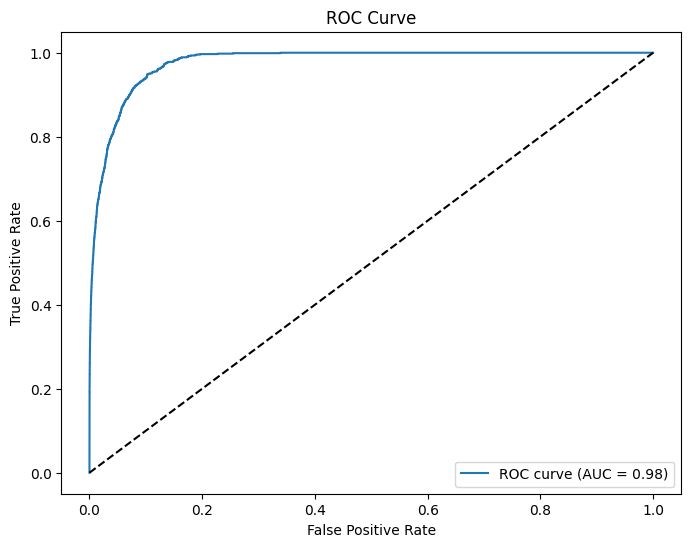

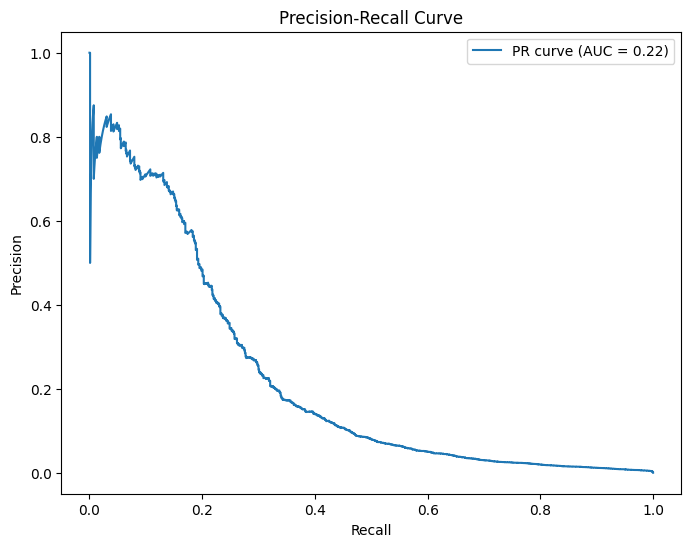

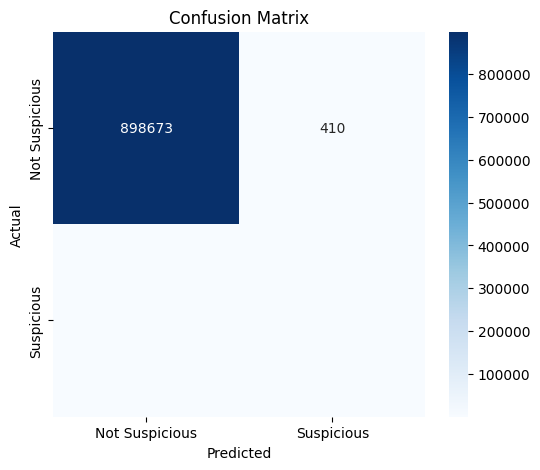

[[898673    410]
 [   689    228]]


In [14]:
# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale lijn (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve 
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

cm = confusion_matrix(y_test, y_pred)
print(cm)

In [16]:
np.save("S-EM_IBM_y_true.npy",y_test)
np.save("S-EM_IBM_y_pred.npy",y_pred)
np.save("S-EM_IBM_y_probs.npy",y_prob)

In [20]:
#optuna
#def objective(trial):
 #   params = {
  #      "objective": "binary:logistic",
   #     "eval_metric": "logloss",
    #    "use_label_encoder": False,
     #   "tree_method": "hist",
      #  "n_estimators": trial.suggest_int("n_estimators", 50, 600),
       # "max_depth": trial.suggest_int("max_depth", 3, 30),
#        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3, log=True),
 #       "subsample": trial.suggest_float("subsample", 0.6, 1.0),
  #      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
   #     "gamma": trial.suggest_float("gamma", 0.0, 5.0),
    #    "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
     #   "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
      #  "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 20.0)
    #}

#    model = XGBClassifier(**params)
 #   model.fit(X_train, y_train_true)

#    y_val_pred = model.predict(X_val)
 #   score = f1_score(y_val_true, y_val_pred)
  #  return score


#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=30, timeout=1200)
#print("Beste hyperparameters:", study.best_params)

# Gebruik beste model
#best_params = study.best_params
#best_params.update({
 #   "objective": "binary:logistic",
  #  "eval_metric": "logloss",
   # "use_label_encoder": False,
    #"tree_method": "hist"
#})
#xgb_best = XGBClassifier(**best_params)

[I 2025-05-12 11:39:17,345] A new study created in memory with name: no-name-57d43556-45dd-4d78-bed8-5ac22f7f1036
[I 2025-05-12 11:39:44,351] Trial 0 finished with value: 0.4354587869362364 and parameters: {'n_estimators': 236, 'max_depth': 9, 'learning_rate': 0.03520633214214851, 'subsample': 0.9517069631390171, 'colsample_bytree': 0.7343766925264049, 'gamma': 0.26646612597504615, 'reg_alpha': 8.690424189108182, 'reg_lambda': 0.21911032156266108, 'scale_pos_weight': 5.923547087189324}. Best is trial 0 with value: 0.4354587869362364.
[I 2025-05-12 11:40:09,125] Trial 1 finished with value: 0.34519572953736655 and parameters: {'n_estimators': 557, 'max_depth': 5, 'learning_rate': 0.08129382175206208, 'subsample': 0.9309508362777675, 'colsample_bytree': 0.9270383416914499, 'gamma': 3.2774079624872012, 'reg_alpha': 8.56009906659763, 'reg_lambda': 7.398163733487068, 'scale_pos_weight': 1.885103846031075}. Best is trial 0 with value: 0.4354587869362364.
[I 2025-05-12 11:40:39,894] Trial 2 f

Beste hyperparameters: {'n_estimators': 438, 'max_depth': 9, 'learning_rate': 0.09627336862920977, 'subsample': 0.8830073592629881, 'colsample_bytree': 0.9971354676815154, 'gamma': 4.103712243452746, 'reg_alpha': 1.9117438145816055, 'reg_lambda': 6.830670563499723, 'scale_pos_weight': 10.385366582173694}
